# Model evaluation

You should already have some idea about what is model evaluation. In the motivation example on the first lecture Jan Maly evaluated model using it's accuracy. During the last two lectures Niek was using F1 socre for model performance evaluation. Let's digg a bit deeper into this problem a learn how to evaluate ML models.

## Classification

### Binary classifier

As the name suggest binary classifier splits data into two classes. Binary classifier usually predict one value or __score__ for each data sample on it's input. The score is usually normalized (values between 0.0 and 1.0) and indicates models certainty that the given sample belongs to the positive class. 

The score itself would not be enough to split data into two classes - you also need __decision threshold__ (sometimes decision boundary or cut-off). Any observations with scores higher than the decision threshold are predicted as the positive class (value `1` or `True`), and scores lower than the decision threshold are predicted as the negative class (value `0` or `False`).

Don't get confused by the terminology of _positive / negative_ or _True / False_ that you would expect for example for SPAM detection classifier. You can use binary classifier any time you need to split your data into two groups. For example you can [download Cats vs. Dogs dataset](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset) and assign `1` to Dogs and `0` to Cats (or vice versa if you are a cat person :) ) and use some binary classifer for the job.

Binary classifier output for data sample is one number between `0.0` and `1.0`. So for the whole dataset you would get many values and you can create histogram of these values to see the distribution. Here is the example of such histogram:

![Binary Classification](images/binary_classification.png)

The `x` axes shows scores from `0.0` to `1.0` and the `y` axes shows volume of predictions for particular score.

OK time to look at some example results and evaluate model that produce them. We will use artifical results to show you how change of output distribution affects metrics.
But for now let's pretend we have trained ML model for SPAM detection. Input to the model is an email and output is score from 0.0 to 1.0. Where 0.0 means that model predicts that given email is not SPAM and 1.0 means that model is 100% sure given email is a SPAM.

Following code will generate two output distribution - one for negative (normal email) and one for positive results (SPAMs). We plot these results and then combine them togeter to simulate output of the ML model on the testing dataset.

__TODO: Not sure if this would be confusing or not? Should I rather use real model and real outputs?__

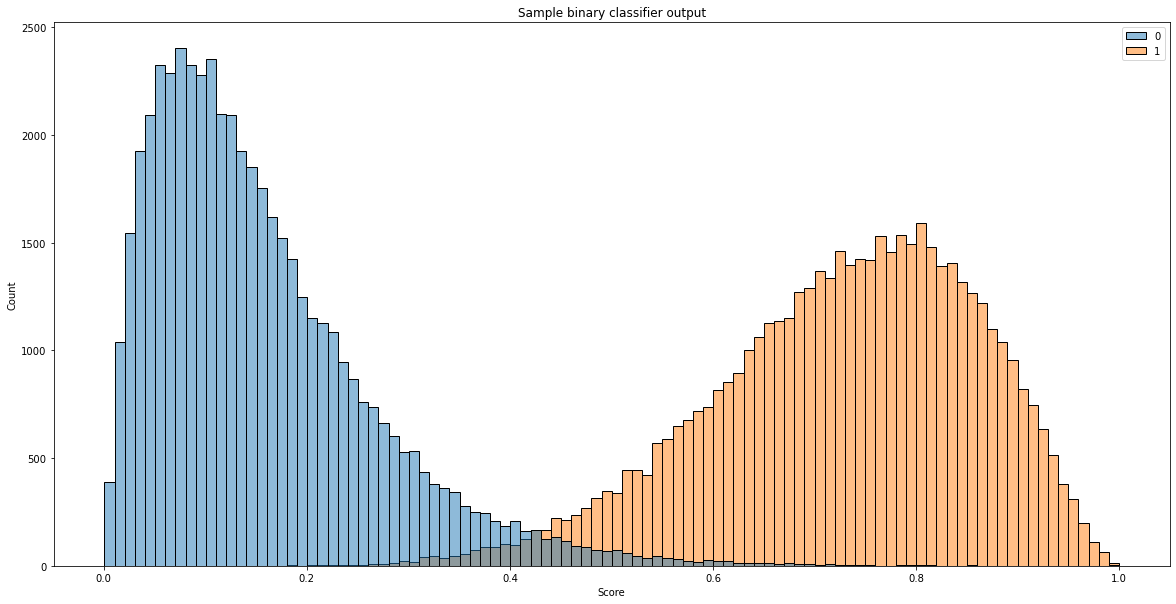

In [1]:
# Import visualization libs (seaborn and matplitlib), scipy for statistical distributions and some other libs for later
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, beta
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Generate random negative and positive sample scores
n_samples = 50000
negative_samples = gamma.rvs(2, size=n_samples)
positive_samples = beta.rvs(8, 3, size=n_samples)

# Normalize outputs to stay in 0.0 to 1.0 range
negative_samples = negative_samples/max(negative_samples)
positive_samples = positive_samples/max(positive_samples)

# Plot histogram of both distributions
_, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=[negative_samples, positive_samples], bins=100)
_ = ax.set_title('Sample binary classifier output')
_ = ax.set(xlabel='Score')

# Combine both distributions to predicted scores and expected correct scores
predicted_scores = list(negative_samples) + list(positive_samples)
true_labels = [0]*len(negative_samples) + [1]*len(positive_samples)

## Important metrics to start with:

### TP (True Positive)

**Description:** A test result that correctly indicates the presence of a condition or characteristic

**In our example:** `SPAM` email classified correctly as `SPAM`

### TN (True Negative)

**Description:** A test result that correctly indicates the absence of a condition or characteristic

**In our example:** `Normal email` classified correctly as `normal email`

### FP (False Positive)

**Description:** A test result which wrongly indicates that a particular condition or attribute is present

**In our example:** `Normal email` classified incorrectly as `SPAM`

### FN (False Negative)

**Description:** A test result which wrongly indicates that a particular condition or attribute is absent

**In our example:** `SPAM` classified incorrectly as `normal email`

How to compute these metrics in our example? Let's look at the output of the classifier and correct labels.

In [2]:
print('Correct\t\tReal\noutput\t\toutput\n----------------------')
for _ in range(10):
    index = random.randint(0, len(true_labels))
    print(f'{true_labels[index]}\t\t{predicted_scores[index]:.3f}')

Correct		Real
output		output
----------------------
1		0.796
0		0.215
0		0.412
0		0.075
1		0.668
0		0.387
0		0.141
1		0.894
1		0.676
1		0.697


We are missing the decision threshold to convert output score into one of the classes! 

What number would you chose for the decision threshold without even looking at the results?

And what number would you chose for the decision threshold if you look at our output distribution?

True positives: 47183
True negatives: 49417
False positives: 583 (normal emails classified as SPAM)
False negatives: 2817 (SMAP classified as normal email)


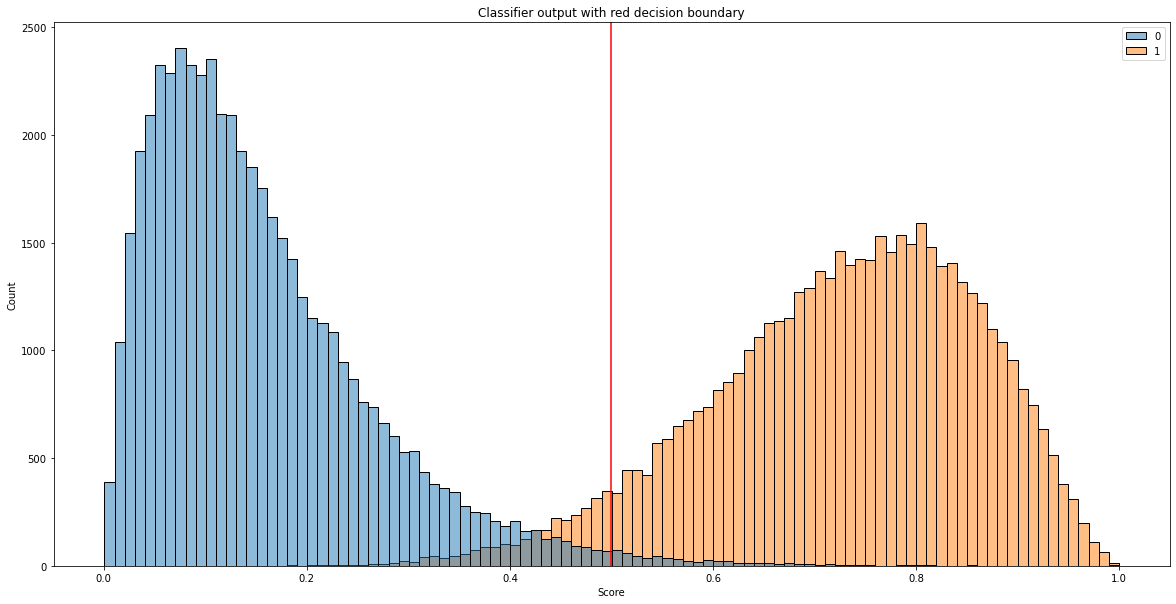

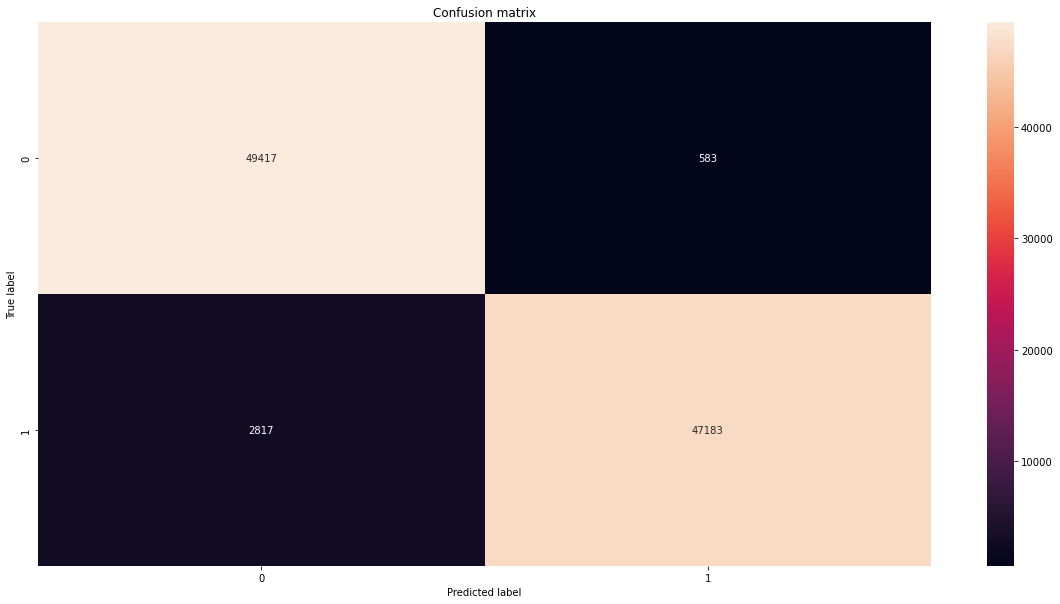

In [3]:
# Play with the threshold value and see how the resuls change
threshold = 0.5

predicted_lables = [1 if label > threshold else 0 for label in predicted_scores]

# Plot histogram with decision threshold
_, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=[negative_samples, positive_samples], bins=100)
plt.axvline(x=threshold, color='red')
_ = ax.set_title('Classifier output with red decision boundary')
_ = ax.set(xlabel='Score')

# Print confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(20,10))
cm = confusion_matrix(true_labels, predicted_lables, normalize=None)
sns.heatmap(cm, annot=True, ax=ax, fmt='d')
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Print TP, TN, FP and FN
print(f'True positives: {cm[1, 1]}\nTrue negatives: {cm[0, 0]}')
print(f'False positives: {cm[0, 1]} (normal emails classified as SPAM)\nFalse negatives: {cm[1, 0]} (SMAP classified as normal email)')

We can combine TP, TN, FP and FN into useful metrics that can tell us more about our classifier in just one number.

Most common ones are:

### Accuracy

Accuracy (acc) is a proportion of correct predictions among the total number of examined samples.

In our case this is a proportion of correctly classified emails among all emails.

$ acc = \dfrac{TP + TN}{TP + TN + FP + FN} $

### Precision

Precision attempts to answer the following question: `What proportion of positive identifications was actually correct?`

In our case it is a fraction of `correctly classified SPAMs (TP)` among all emails labeled by the model as `SPAM`

$ precision = \dfrac{TP}{TP + FP} $

### Recall

Recall attempts to answer the following question: `What proportion of actual positives was identified correctly?`

In our case it is a fraction of `correctly classified SPAMs (TP)` among all correctly plus incorrectly classified emails marked as `SPAM`

$ recall = \dfrac{TP}{TP + FN} $

You can find many more matrics based on TP, TN, FP and FN [here](https://en.wikipedia.org/wiki/Precision_and_recall)

Let's compute accuracy, precision and recall for our example.

In [4]:
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

acc = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(f'Accuracy: {acc:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}')

Accuracy: 0.9660
Precision: 0.9878
Recall: 0.9437


We already mentioned F1 score in prevous lectures but what it is actually?

### F1 score

F1 score combines precision and recall into a single metric by taking their harmonic mean.

$ F_1 = 2 \dfrac{precision * recall}{precision + recall} = \dfrac{2TP}{2TP + FP + FN}$

In F1 score the relative contribution of precision and recall to the F1 score are equal. But sometimes recall is litle more important for us then precission, sometimes recall is much more important for us then precission and sometimes the oposite. This is where $F_\beta$ score comes in.

### $F_\beta$ score

A more general F score that uses a positive real factor $\beta$, where $\beta$ is chosen such that recall is considered $\beta$ times as important as precision.

Two commonly used values for $\beta$ are 2, which weighs recall higher than precision, and 0.5, which weighs recall lower than precision.

$ F_\beta = (1+\beta^2)\dfrac{precision * recall}{(\beta^2 precision) + recall} = \dfrac{(1+\beta^2)TP}{(1+\beta^2)TP + \beta^2 FN + FP}$

In [5]:
f1 = 2*(recall*precision)/(recall+precision)

def f_beta(beta, precision, recall):
    return (1 + beta**2)*precision*recall/((beta**2 * precision) + recall)

f2 = f_beta(2, precision, recall)
f05 = f_beta(0.5, precision, recall)

print(f'f1 score: {f1:.4f}\nf2 score: {f2:.4f}\nf0.5 score: {f05:.4f}')

f1 score: 0.9652
f2 score: 0.9522
f0.5 score: 0.9786


### ROC - AUC

**Receiver operating characteristic curve (ROC)** or **Area Under the Curve (AUC)** is equal to the probability that model will rank a randomly chosen positive smaple higher than a randomly chosen negative one.

Can you guess what is the meaning of the red line?

AUC = 0.9969054778


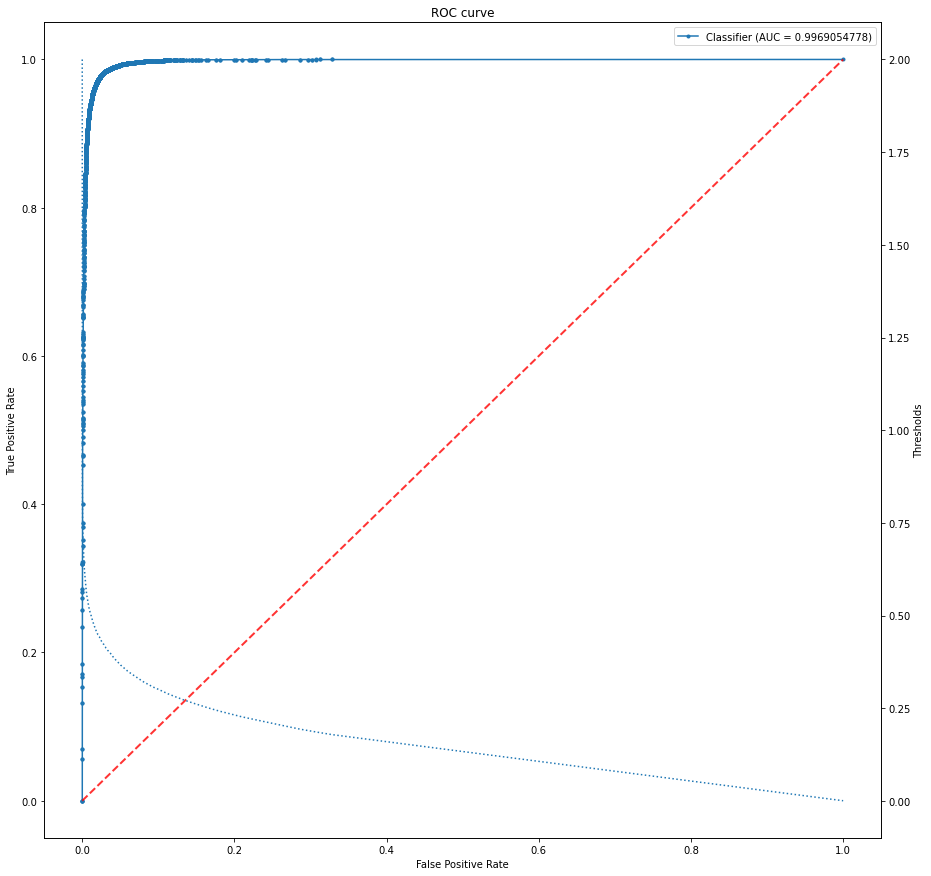

In [6]:
# Plot AUC (ROC)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# compute metrics
score = roc_auc_score(true_labels, predicted_scores)
first_m, second_m, thresholds = roc_curve(true_labels, predicted_scores)
print(f'AUC = {score}')

# plot classifier
ax.plot(first_m, second_m, marker='.', label=f'Classifier (AUC = {score})')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

# plot thresholds
ax2 = ax.twinx()
ax2.plot(first_m[:len(thresholds)], thresholds, linestyle=':')
ax2.set_ylabel('Thresholds')
    
# annotate plot
ax.set_title('ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# show legend
_ = ax.legend()

### Multiclass classifier

In [ ]:
# Exmplain the difference from binary and what change

# Show the trick to create N binary classifiers instead of 1 multiclas for N classes and why to use it

### Regression models

In [ ]:
# TODO

**TODO**

**Bias & variance / overfitting & underfitting**
https://medium.com/analytics-vidhya/elucidating-bias-variance-under-fitting-and-over-fitting-273846621622

**Some other usefull sources**
https://neptune.ai/blog/the-ultimate-guide-to-evaluation-and-selection-of-models-in-machine-learning
https://medium.datadriveninvestor.com/k-fold-cross-validation-6b8518070833